In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
import numpy as np
import gzip
import json
import re
import copy
from ineqpy import gini

In [16]:
df = pd.read_csv('results_05_19.csv.gz')

# if this is the result of multiple runs, calculate mean and std per parent run_id
temp = df.groupby('parent_run_id').agg([np.mean, np.std])[['avg_request_lengths', '20/20_ratio', 'atkinson', 'gini', 'avg_time_cruising','avg_time_serving', 'avg_time_to_request', 'avg_time_waiting',
       'avg_trip_income', 'std_time_cruising', 'std_time_serving',
       'std_time_to_request', 'std_time_waiting', 'std_trip_income']]
temp.columns = ['_'.join(col).strip() for col in temp.columns.values]

# append calculated values to other conf columns
df = pd.concat([df.groupby('parent_run_id').first(),temp],axis=1)

df['rho'] = round(1/df['d']**2*1e6,0)

cond_waiting = (df['behaviour']=='stay') & (df['initial_conditions']=='base')# & pd.isnull(df['reset_time'])
cond_cruising = (df['behaviour']=='go_back') & (df['initial_conditions']=='base')# & pd.isnull(df['reset_time'])
cond_simple_geom  = (df["geom"]==0)

colors = ["#44af69", "#c5283d", "#2E86AB", "#182825", "#efcb00","#FFC0CB","#FF8C00"]
markers = ['o','v','s','']
markers_all = ['o','v','s','X','p']
linestyles=['-','--','-.','']
st = dict(color=colors[0:3],linewidth=2,markersize=7,legend=False,style='.-',alpha=0.7)

fs = 15

# Figure 1 - \$, I vs. R

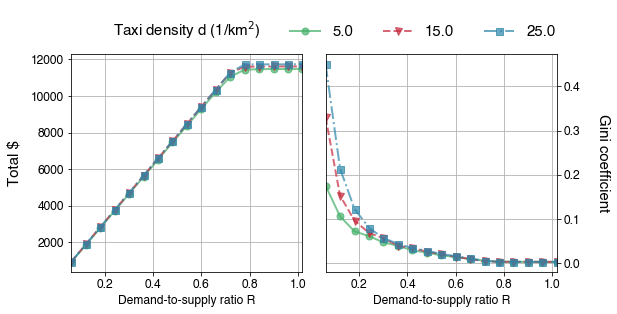

In [60]:
cond_d_slice = (df['rho'].map(lambda i: int(round(i,0)) in [5,15,25]))
cond_R_slice = (df['R'].map(lambda r: int(round(r*100,0))%6==0))
cond_alg = (df['matching']=='nearest')
cond = cond_simple_geom&cond_d_slice&cond_waiting&cond_R_slice      
      
fig,ax = plt.subplots(1,2,figsize=(8.7,4))
plt.rcParams['font.size']=fs

df[cond]\
.pivot_table(values='avg_trip_income_mean',index='R',columns='rho',aggfunc=lambda x: x)\
.plot(ax=ax[0],**st)
ax[0].set_ylabel("Total $", labelpad=10, fontsize=fs)

handles, labels = ax[0].get_legend_handles_labels()

    
df[cond]\
.pivot_table(values='gini_mean',index='R',columns='rho',aggfunc=lambda x: x)\
.plot(ax=ax[1],**st)

ax[1].set_ylabel("Gini coefficient",labelpad=30,rotation=-90,fontsize=fs)

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ph = [plt.plot([],marker="", ls="")[0]] # Canvas
handles = ph + handles
labels = [r"Taxi density d (1/km$^2$)"] + labels  # Merging labels

for a in ax:
    a.set_xlabel('Demand-to-supply ratio R')
    for i,l in enumerate(a.lines[0:3]):
        l.set_marker(markers[i])
        l.set_linestyle(linestyles[i])

plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07),ncol=4,frameon=False,)
plt.subplots_adjust(wspace=0.1)
fig.savefig('R_fig.pdf',bbox_inches='tight',pad_inches=0)

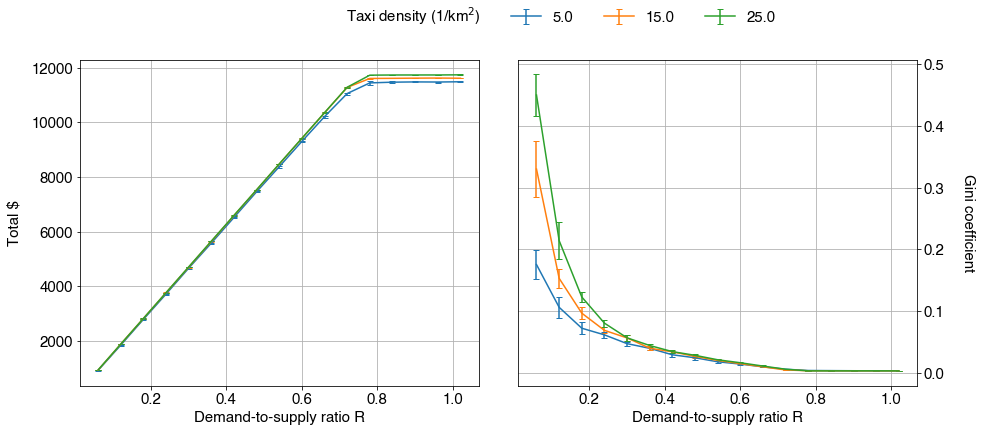

In [43]:
# with errorbars
# very small errors
# simulations roughly give the same results


cond_d_slice = (df['rho'].map(lambda i: int(round(i,0)) in [5,15,25]))
cond_R_slice = (df['R'].map(lambda r: int(round(r*100,0))%6==0))
cond_alg = (df['matching']=='nearest')
cond = cond_simple_geom&cond_d_slice&cond_waiting&cond_R_slice      

plt.rcParams['font.size']=15      
fig,ax = plt.subplots(1,2,figsize=(15,6))

# df[cond]\
# .pivot_table(values='avg_trip_income_mean',index='R',columns='rho',aggfunc=lambda x: x)\
# .plot(ax=ax[0],**st)
# ax[0].set_ylabel("Total $", labelpad=10)

errorbars1 =  df[cond]\
.pivot_table(values=['avg_trip_income_mean','avg_trip_income_std'],index='R',columns='rho',aggfunc=lambda x: x)
for d in errorbars1["avg_trip_income_mean"].columns:
    ax[0].errorbar(x=errorbars1["avg_trip_income_mean"].index, 
                   y=errorbars1["avg_trip_income_mean"][d],
                   yerr =errorbars1["avg_trip_income_std"][d],
                  capsize=3,label=str(d))

handles, labels = ax[0].get_legend_handles_labels()

    
# df[cond]\
# .pivot_table(values='gini_mean',index='R',columns='rho',aggfunc=lambda x: x)\
# .plot(ax=ax[1],**st)

errorbars2 =  df[cond]\
.pivot_table(values=['gini_mean','gini_std'],index='R',columns='rho',aggfunc=lambda x: x)
for d in errorbars2["gini_mean"].columns:
    ax[1].errorbar(x=errorbars2["gini_mean"].index, 
                   y=errorbars2["gini_mean"][d],
                   yerr =errorbars2["gini_std"][d],
                  capsize=3)

ax[0].set_ylabel("Total $", labelpad=10, fontsize=fs)
ax[1].set_ylabel("Gini coefficient",labelpad=30,rotation=-90,fontsize=fs)


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ph = [plt.plot([],marker="", ls="")[0]] # Canvas
handles = ph + handles
labels = [r"Taxi density (1/km$^2$)"] + labels  # Merging labels

for a in ax:
    a.set_xlabel('Demand-to-supply ratio R')
#     for i,l in enumerate(a.lines[0:3]):
#         #l.set_marker(markers[i])
#         l.set_linestyle(linestyles[i])

plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),ncol=4,frameon=False,)
plt.subplots_adjust(wspace=0.1)
fig.savefig('R_fig_errorbars.pdf',pad_inches=0.3)

# Figure 2 \$,I vs. d

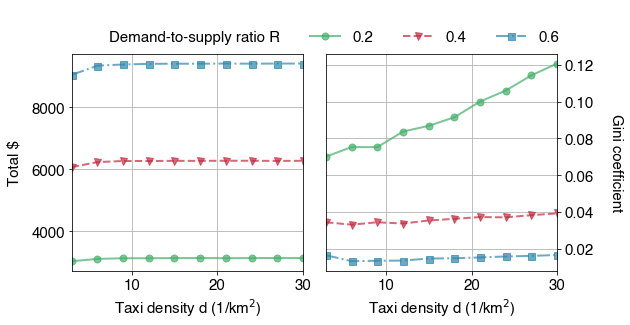

In [63]:
cond_R_slice = (df['R'].map(lambda i: i in [0.2,0.4,0.6]))
cond_alg = (df['matching']=='nearest')
cond_d_slice = (df['rho'].map(lambda rho: rho in np.linspace(3,30,10)))
cond = cond_waiting&cond_simple_geom&cond_R_slice&cond_alg&cond_d_slice

fig,ax = plt.subplots(1,2,figsize=(8.7,4))
plt.rcParams['font.size']=fs

df[cond]\
.pivot_table(values='avg_trip_income_mean',index='rho',columns='R',aggfunc=lambda x: x)\
.plot(ax=ax[0],**st)
ax[0].set_xlabel(r'Taxi density d (1/km$^2$)')
ax[0].set_ylabel("Total $", labelpad=10, fontsize=fs)
#ax[0].invert_xaxis()
#ax[0].set_xlim(0,50)
#ax[0].yaxis.set_ticks((np.arange(0, 4500, step=1000)))
handles, labels = ax[0].get_legend_handles_labels()



df[cond]\
.pivot_table(values='gini_mean',index='rho',columns='R',aggfunc=lambda x: x)\
.plot(ax=ax[1],**st)
ax[1].set_xlabel(r'Taxi density d (1/km$^2$)')
ax[1].set_ylabel("Gini coefficient",labelpad=30,rotation=-90,fontsize=fs)
#ax[1].invert_xaxis()
#ax[1].set_xlim(0,50)
#ax[1].yaxis.set_ticks((np.arange(0, 0.25, step=0.05)))

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ph = [plt.plot([],marker="", ls="")[0]] # Canvas
handles = ph + handles
labels = ["Demand-to-supply ratio R"] + labels  # Merging labels

for a in ax:
    for i,l in enumerate(a.lines):
        l.set_marker(markers[i])
        l.set_linestyle(linestyles[i])

plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07),ncol=4,frameon=False,)
plt.subplots_adjust(wspace=0.1)
fig.savefig('d_fig.pdf',bbox_inches="tight",pad_inches=0)

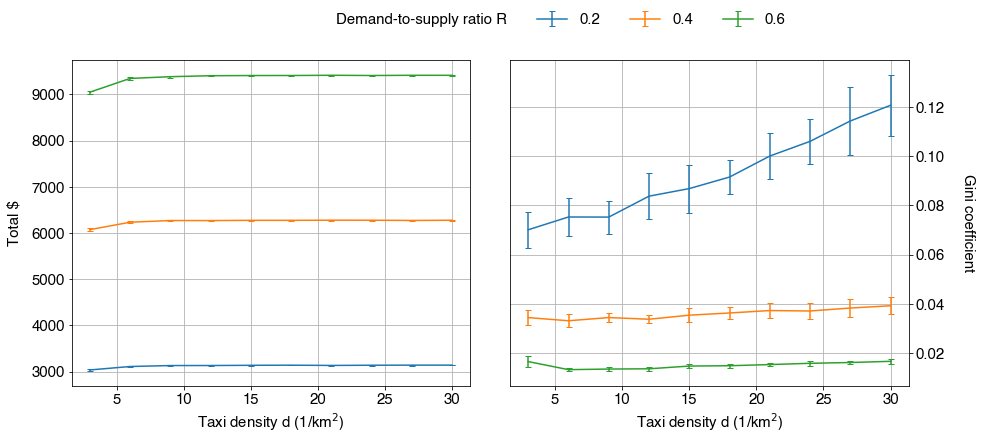

In [42]:
# with errorbars
# very small errors
# simulations roughly give the same results


cond_R_slice = (df['R'].map(lambda i: i in [0.2,0.4,0.6]))
cond_alg = (df['matching']=='nearest')
cond_d_slice = (df['rho'].map(lambda rho: rho in np.linspace(3,30,10)))
cond = cond_waiting&cond_simple_geom&cond_R_slice&cond_alg&cond_d_slice 

plt.rcParams['font.size']=15      
fig,ax = plt.subplots(1,2,figsize=(15,6))

# df[cond]\
# .pivot_table(values='avg_trip_income_mean',index='R',columns='rho',aggfunc=lambda x: x)\
# .plot(ax=ax[0],**st)
# ax[0].set_ylabel("Total $", labelpad=10)

errorbars1 =  df[cond]\
.pivot_table(values=['avg_trip_income_mean','avg_trip_income_std'],index='rho',columns='R',aggfunc=lambda x: x)
for R in errorbars1["avg_trip_income_mean"].columns:
    ax[0].errorbar(x=errorbars1["avg_trip_income_mean"].index, 
                   y=errorbars1["avg_trip_income_mean"][R],
                   yerr =errorbars1["avg_trip_income_std"][R],
                  capsize=3,label=str(R))

handles, labels = ax[0].get_legend_handles_labels()

    
# df[cond]\
# .pivot_table(values='gini_mean',index='R',columns='rho',aggfunc=lambda x: x)\
# .plot(ax=ax[1],**st)

errorbars2 =  df[cond]\
.pivot_table(values=['gini_mean','gini_std'],index='rho',columns='R',aggfunc=lambda x: x)
for R in errorbars2["gini_mean"].columns:
    ax[1].errorbar(x=errorbars2["gini_mean"].index, 
                   y=errorbars2["gini_mean"][R],
                   yerr =errorbars2["gini_std"][R],
                  capsize=3)

ax[0].set_ylabel("Total $", labelpad=10, fontsize=fs)
ax[1].set_ylabel("Gini coefficient",labelpad=30,rotation=-90,fontsize=fs)


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ph = [plt.plot([],marker="", ls="")[0]] # Canvas
handles = ph + handles
labels = ["Demand-to-supply ratio R"] + labels  # Merging labels

for a in ax:
    a.set_xlabel(r'Taxi density d (1/km$^2$)')

plt.figlegend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),ncol=4,frameon=False,)
plt.subplots_adjust(wspace=0.1)
fig.savefig('d_fig_errorbars.pdf',pad_inches=0.3)

# Figure 3  - Geometries

In [5]:
conf = {
    "n":40,
    "m":40,
    "num_taxis":3,
    "request_rate":1,
    "log":False,
    "max_time":1000,
    "length":1000,
    "hard_limit":10,
    "show_map_labels":False,
    "behaviour" : "stay",
    "initial_conditions": "home",
    "show_pending":False,
    "show_plot":True,
    "matching":"baseline_random_user_nearest_taxi",
    "request_origin_distributions": [
        {
            "location": [
                5,
                5
            ],
            "strength": 1,
            "sigma": 5
        }
    ]
}

In [6]:
geom_specs = [json.loads(e.strip('\n')) for e in open('../configs/geom_specification_compact.json').readlines()]

In [7]:
import sys
sys.path.insert(1,'..')
from geometry import City

In [8]:
def plot_geoms(ind,num=int(5e5)):
    if 'request_destination_distributions' in conf:
        del conf['request_destination_distributions']
    if 'request_origin_distributions' in conf:
        del conf['request_origin_distributions']
    conf.update(geom_specs[ind])
    c = City(**conf)
    o = []
    d = []
    inds = []
    for i in range(num):
        ox,oy,dx,dy = c.create_one_request_coord()
        o.append((ox,oy))
        d.append((dx,dy))
    o = np.array(o)
    d = np.array(d)
        
    return {"o":o,"d":d}

In [9]:
geom_plot_dict = {i: plot_geoms(i) for i in range(7)}    

In [10]:
geom_descr = {
    0: "Small single-center",
    1: "Big single-center",
    2: "Outwards flow",
    3: "Inwards flow",
    4: "To airport",
    5: "From airport",
    6: "Two centers"
}

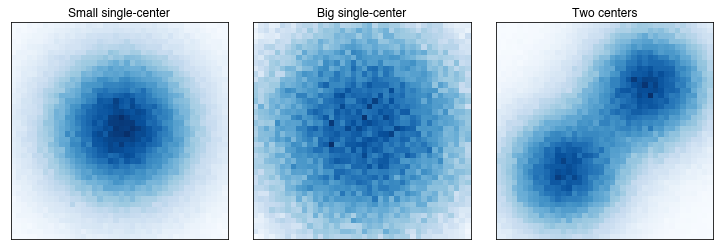

In [11]:
fig,ax = plt.subplots(1,3,figsize=(13,4))
for i,elem in enumerate([0,1,6]):
    o = geom_plot_dict[elem]["o"]
    
    ax[i].hist2d(o[:,0],o[:,1],bins=(conf['n'],conf['m']),range=((0,conf['n']),(0,conf['m'])),cmap='Blues')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_aspect('equal')
    ax[i].set_title(geom_descr[elem])
    
plt.subplots_adjust(wspace=0.01)  
fig.savefig('geom1.pdf')

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(8,8.5))
for i in [2,3]:
    twinax = ax[i%2]
    o = geom_plot_dict[i]["o"]
    d = geom_plot_dict[i]["d"]
    
    twinax[0].hist2d(o[:,0],o[:,1],bins=(conf['n'],conf['m']),range=((0,conf['n']),(0,conf['m'])),cmap='Blues')
    twinax[0].get_xaxis().set_visible(False)
    twinax[0].get_yaxis().set_visible(False)
    twinax[0].set_aspect('equal')
    twinax[0].annotate(geom_descr[i],fontsize=18,xy=(0.8,1.05),xycoords='axes fraction')

    
    twinax[1].hist2d(d[:,0],d[:,1],bins=(conf['n'],conf['m']),range=((0,conf['n']),(0,conf['m'])),cmap='Blues')
    twinax[1].get_xaxis().set_visible(False)
    twinax[1].get_yaxis().set_visible(False)
    twinax[1].set_aspect('equal')
fig.subplots_adjust(wspace=0.05)
fig.savefig('geom2.pdf')

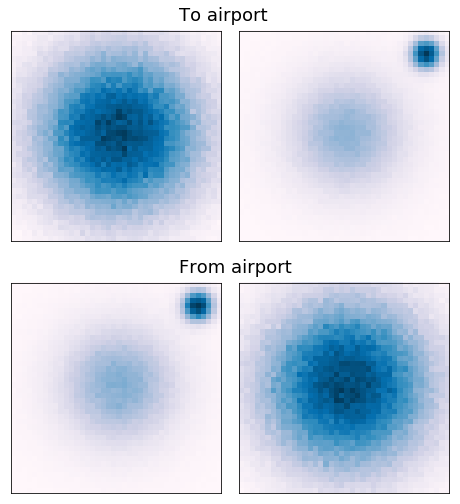

In [192]:
fig,ax = plt.subplots(2,2,figsize=(8,8.5))
for i in [4,5]:
    twinax = ax[i%2]
    o = geom_plot_dict[i]["o"]
    d = geom_plot_dict[i]["d"]
    
    twinax[0].hist2d(o[:,0],o[:,1],bins=(conf['n'],conf['m']),range=((0,conf['n']),(0,conf['m'])),cmap='PuBu')
    twinax[0].get_xaxis().set_visible(False)
    twinax[0].get_yaxis().set_visible(False)
    twinax[0].set_aspect('equal')
    twinax[0].annotate(geom_descr[i],fontsize=18,xy=(0.8,1.05),xycoords='axes fraction')

    
    twinax[1].hist2d(d[:,0],d[:,1],bins=(conf['n'],conf['m']),range=((0,conf['n']),(0,conf['m'])),cmap='PuBu')
    twinax[1].get_xaxis().set_visible(False)
    twinax[1].get_yaxis().set_visible(False)
    twinax[1].set_aspect('equal')
fig.subplots_adjust(wspace=0.05)
fig.savefig('geom3.png')

# Figure 4  - Income and inequality in different geometries

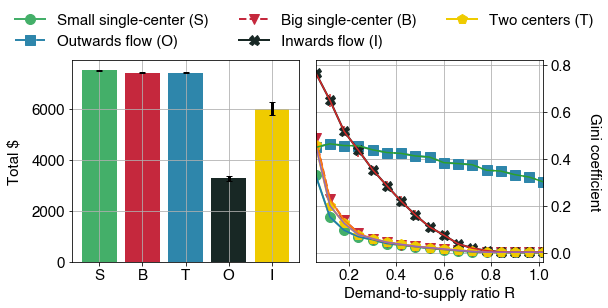

In [55]:
geom_descr = {
    0: "Small single-center",
    1: "Big single-center",
    2: "Outwards flow",
    3: "Inwards flow",
    4: "To airport",
    5: "From airport",
    6: "Two centers"
}

cond_d_slice = (df['rho']==15)
cond_R_slice = df['R'].map(lambda r: int(round(100*r,0))%6==0)
cond_alg = (df['matching']=='nearest')
cond_geom = df['geom'].map(lambda g: int(g) in [0,1,2,3,6])
cond = cond_waiting&cond_d_slice&cond_alg&cond_geom&cond_R_slice

fig,ax = plt.subplots(1,2,figsize=(8.7,4.5))
plt.rcParams['font.size']=fs

s = df[cond]\
.pivot_table(values='avg_trip_income_mean',index='R',columns='geom',aggfunc=lambda x: x).loc[0.48]
ax[0].bar(range(5),s.loc[[0,1,6,2,3]],color=colors)
ax[0].set_xticks(range(5))
ax[0].set_xticklabels(map(lambda k: geom_descr[k][0],[0,1,6,2,3]))
ax[0].set_ylabel("Total $", labelpad=10)

serr = df[cond]\
.pivot_table(values='avg_trip_income_std',index='R',columns='geom',aggfunc=lambda x: x).loc[0.48]
ax[0].errorbar(x=range(5),y=s.loc[[0,1,6,2,3]],yerr=serr.loc[[0,1,6,2,3]],linestyle='',elinewidth=3,color='black',capsize=3)


d = df[cond]\
.pivot_table(values='gini_mean',index='R',columns='geom',aggfunc=lambda x: x)

d.plot(ax=ax[1],style=linestyles,color=colors,linewidth=2,markersize=10,legend=False)

derr = df[cond]\
.pivot_table(values='gini_std',index='R',columns='geom',aggfunc=lambda x: x)
for i, line in enumerate(ax[1].get_lines()):
    line.set_marker(markers_all[i])
for g in derr.columns:
    ax[1].errorbar(x=d.index, y=d[g], yerr=derr[g])

ax[1].set_ylabel("Gini coefficient",labelpad=30,rotation=-90)
ax[1].set_xlabel('Demand-to-supply ratio R')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

handles, labels = ax[1].get_legend_handles_labels()
plt.figlegend(np.array(handles)[[0,2,1,3,4]], map(lambda k: geom_descr[int(k)] + ' (' + geom_descr[int(k)][0] + ')',[0,2,1,3,6]), loc='upper center',ncol=3,frameon=False)
plt.subplots_adjust(wspace=0.1,top=0.15)
plt.tight_layout()

fig.savefig('geom_fig.pdf',bbox_inches="tight",pad_inches=0)

# Figure 5 - income distributions for different strategies 

In [23]:
def get_incomes(parent_run_id):
    """
    Given a parent_run_id, this function returns the incomes of all taxis at the end of all the simulations.
    """
    
    e=[]
    for r in range(10):
        fname = '../results/run_' + parent_run_id + '_run_' +str(r)+ '_per_taxi_metrics.json.gz'
        try:
            e.append(gzip.open(fname,'rb').readlines()[-1])
        except FileNotFoundError:
            e.append('')
    ptm = []
    for x in e:
        if x!='':
            ptm += json.loads(re.sub('nan','null',x.decode('utf8').strip('\n')))['trip_income']
    return ptm

## One figure

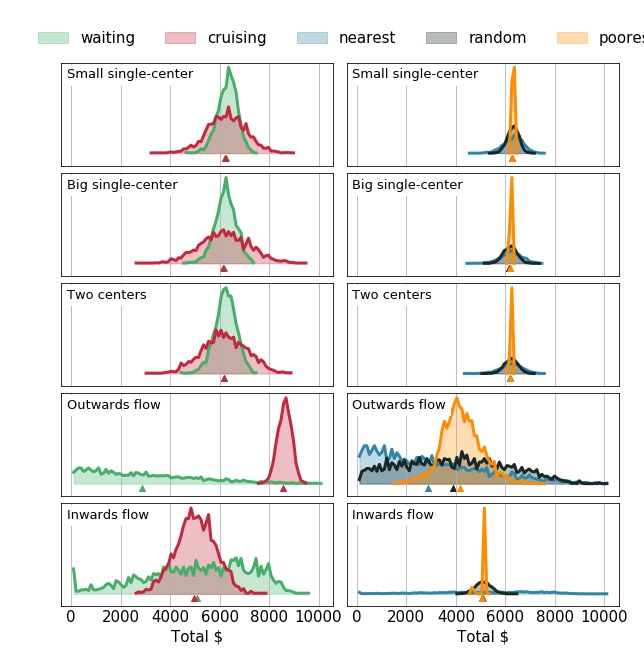

In [142]:
# selecting a specific part of the dataframe

cond1 = df['rho']==15
cond2 = df['R']==0.4
cond3 = df['matching'] == 'nearest'

cond4 = (df['behaviour']=='stay') & (df['initial_conditions']=='base')# & pd.isnull(df['reset_time'])
cond5 = (df['behaviour']=='go_back') & (df['initial_conditions']=='base')# & pd.isnull(df['reset_time'])

# waiting
sdf1 = copy.deepcopy(df[cond1&cond2&cond3&cond4])
sdf1['behav'] = 'waiting'
# cruising
sdf2 = copy.deepcopy(df[cond1&cond2&cond3&cond5])
sdf2['behav'] = 'cruising'

sdf = pd.concat([sdf1,sdf2],ignore_index=False)

sdf['incomes'] = sdf.index.map(get_incomes)
sdf = sdf[['geom','incomes','behav']]

sdf_flatten = sdf\
    .set_index(['geom','behav'])['incomes']\
    .apply(pd.Series)\
    .stack()\
    .reset_index(level=0)\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename(columns={0:'income'})

sdf['mean_incomes'] = sdf['incomes'].map(lambda l: np.mean(l))

sdf['gini'] = sdf['incomes'].map(lambda l: gini(np.array(l)))

total_min1 = min(sdf['incomes'].map(lambda l: min(l)))
total_max1 = max(sdf['incomes'].map(lambda l: max(l)))

data1 = sdf.pivot_table(values='incomes',index='geom',columns='behav',aggfunc=lambda x:x)


plt.rcParams['figure.figsize']=10,10
fig, ax = plt.subplots(5,2,sharex=True)

for i,g in enumerate([0,1,6,2,3]):
    y1,x1 = np.histogram(data1['waiting'][g],bins=100,range=(0,10100),density=True)
    filt1=(y1!=0)
    y2,x2 = np.histogram(data1['cruising'][g],bins=100,range=(0,10100),density=True)
    filt2=(y2!=0)
    
    ax[i,0].plot(x1[1:][filt1],y1[filt1],'-',lw=3,color=colors[0])
    ax[i,0].plot(x1[1:][filt2],y2[filt2],'-',lw=3,color=colors[1])

    ymax = ax[i,0].get_ylim()[1]
    offset=0.05
    ax[i,0].scatter(np.mean(data1['waiting'][g]),-ymax*offset,marker='^',color=colors[0])
    ax[i,0].scatter(np.mean(data1['cruising'][g]), -ymax*offset,marker='^',color=colors[1])
    
    ax[i,0].fill_between(x1[1:][filt1],y1[filt1],y2=0,color=colors[0],alpha=0.3,label="waiting")
    ax[i,0].fill_between(x1[1:][filt2],y2[filt2],y2=0,color=colors[1],alpha=0.3,label="cruising")
    
    ax[i,0].grid(which='major',axis='y')
    ax[i,0].get_yaxis().set_visible(False)
    ax[i,0].tick_params(length=0)
    
    ax[i,0].annotate(s=geom_descr[g],xy=(0.02,0.85),xycoords='axes fraction',backgroundcolor='white',fontsize=13)    

ax[4,0].set_xlabel('Total $')
#fig.legend(*ax[0].get_legend_handles_labels(),loc=(0.2,0.92),frameon=False,ncol=2)
#fig.savefig('different_strategy.pdf',bbox_inches='tight')

# selecting a specific part of the dataframe

cond1 = (df['d']== 258)
cond2 = (df['R']==0.4)
cond4 = (df['behaviour']=='stay') & (df['initial_conditions']=='base')

# waiting
sdf = copy.deepcopy(df[cond1&cond2&cond4])

sdf.index = sdf.index.map(lambda s: re.sub('random','random_limited',s))

sdf['incomes'] = sdf.index.map(get_incomes)
sdf = sdf[['geom','incomes','matching']]
sdf_flatten = sdf\
    .set_index(['geom','matching'])['incomes']\
    .apply(pd.Series)\
    .stack()\
    .reset_index(level=0)\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename(columns={0:'income'})
    
sdf['mean_incomes'] = sdf['incomes'].map(lambda l: np.mean(l))
t = sdf.pivot_table(index='geom',values='mean_incomes',columns='matching')#.plot(style='o',ax=ax)

data2 = sdf.pivot_table(values='incomes',index='geom',columns='matching',aggfunc=lambda x:x)

for i,g in enumerate([0,1,6,2,3]):
    y1,x1 = np.histogram(data2['nearest'][g],bins=100,range=(0,10100),density=True)
    filt1=(y1!=0)|(np.roll(y1,1)!=0)|(np.roll(y1,-1)!=0)
    
    y2,x2 = np.histogram(data2['random'][g],bins=100,range=(0,10100),density=True)
    filt2=(y2!=0)|(np.roll(y2,1)!=0)|(np.roll(y2,-1)!=0)
    
    y3,x3 = np.histogram(data2['poorest'][g],bins=100,range=(0,10100),density=True)
    filt3=(y3!=0)|(np.roll(y3,1)!=0)|(np.roll(y3,-1)!=0)
    
    
    ax[i,1].plot(x1[1:][filt1],y1[filt1],'-',lw=3,color=colors[2])
    ax[i,1].plot(x1[1:][filt2],y2[filt2],'-',lw=3,color=colors[3])
    ax[i,1].plot(x1[1:][filt3],y3[filt3],'-',lw=3,color=colors[6])
    

    ymax = ax[i,1].get_ylim()[1]
    offset=0.05
    ax[i,1].scatter(np.mean(data2['nearest'][g]),-ymax*offset,marker='^',color=colors[2])
    ax[i,1].scatter(np.mean(data2['random'][g]), -ymax*offset,marker='^',color=colors[3])
    ax[i,1].scatter(np.mean(data2['poorest'][g]),-ymax*offset,marker='^',color=colors[6])
    
    ax[i,1].fill_between(x1[1:][filt1],y1[filt1],y2=0,color=colors[2],alpha=0.3,label="nearest")
    ax[i,1].fill_between(x1[1:][filt2],y2[filt2],y2=0,color=colors[3],alpha=0.3,label="random")
    ax[i,1].fill_between(x1[1:][filt3],y3[filt3],y2=0,color=colors[6],alpha=0.3,label="poorest")
    
    ax[i,1].grid(which='major',axis='y')
    ax[i,1].get_yaxis().set_visible(False)
    ax[i,1].tick_params(length=0)

    ax[i,1].annotate(s=geom_descr[g],xy=(0.02,0.85),xycoords='axes fraction',backgroundcolor='white',fontsize=13)
    
ax[4,1].set_xlabel('Total $')
h1,l1 = ax[0,0].get_legend_handles_labels()
h2,l2 = ax[0,1].get_legend_handles_labels()
fig.legend(*(h1+h2,l1+l2),loc=(0.05,0.92),frameon=False,ncol=5)
#fig.subplots_adjust(hspace=0.07)
plt.savefig('different_layouts.pdf',bbox_inches='tight')
fig.subplots_adjust(hspace=0.07,wspace=0.05)

## Two figures

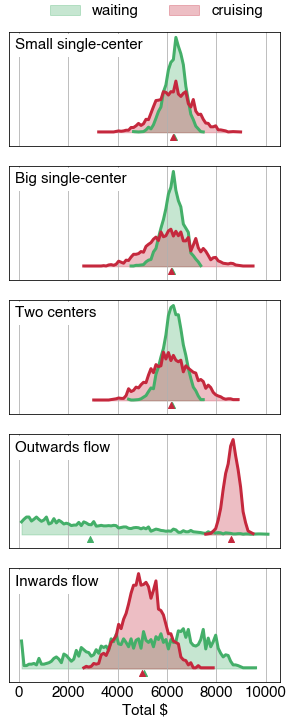

In [56]:
# selecting a specific part of the dataframe

cond1 = df['rho']==15
cond2 = df['R']==0.4
cond3 = df['matching'] == 'nearest'

cond4 = (df['behaviour']=='stay') & (df['initial_conditions']=='base')# & pd.isnull(df['reset_time'])
cond5 = (df['behaviour']=='go_back') & (df['initial_conditions']=='base')# & pd.isnull(df['reset_time'])

# waiting
sdf1 = copy.deepcopy(df[cond1&cond2&cond3&cond4])
sdf1['behav'] = 'waiting'
# cruising
sdf2 = copy.deepcopy(df[cond1&cond2&cond3&cond5])
sdf2['behav'] = 'cruising'

sdf = pd.concat([sdf1,sdf2],ignore_index=False)

sdf['incomes'] = sdf.index.map(get_incomes)
sdf = sdf[['geom','incomes','behav']]

sdf_flatten = sdf\
    .set_index(['geom','behav'])['incomes']\
    .apply(pd.Series)\
    .stack()\
    .reset_index(level=0)\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename(columns={0:'income'})

sdf['mean_incomes'] = sdf['incomes'].map(lambda l: np.mean(l))

sdf['gini'] = sdf['incomes'].map(lambda l: gini(np.array(l)))

total_min1 = min(sdf['incomes'].map(lambda l: min(l)))
total_max1 = max(sdf['incomes'].map(lambda l: max(l)))

data1 = sdf.pivot_table(values='incomes',index='geom',columns='behav',aggfunc=lambda x:x)


plt.rcParams['figure.figsize']=4.35,10
plt.rcParams['font.size']=fs
fig, ax = plt.subplots(5,1,sharex=True)

for i,g in enumerate([0,1,6,2,3]):
    y1,x1 = np.histogram(data1['waiting'][g],bins=100,range=(0,10100),density=True)
    filt1=(y1!=0)
    y2,x2 = np.histogram(data1['cruising'][g],bins=100,range=(0,10100),density=True)
    filt2=(y2!=0)
    
    ax[i].plot(x1[1:][filt1],y1[filt1],'-',lw=3,color=colors[0])
    ax[i].plot(x1[1:][filt2],y2[filt2],'-',lw=3,color=colors[1])

    ymax = ax[i].get_ylim()[1]
    offset=0.05
    ax[i].scatter(np.mean(data1['waiting'][g]),-ymax*offset,marker='^',color=colors[0])
    ax[i].scatter(np.mean(data1['cruising'][g]), -ymax*offset,marker='^',color=colors[1])
    
    ax[i].fill_between(x1[1:][filt1],y1[filt1],y2=0,color=colors[0],alpha=0.3,label="waiting")
    ax[i].fill_between(x1[1:][filt2],y2[filt2],y2=0,color=colors[1],alpha=0.3,label="cruising")
    
    ax[i].grid(which='major',axis='y')
    ax[i].get_yaxis().set_visible(False)
    ax[i].tick_params(length=0)
    
    ax[i].annotate(s=geom_descr[g],xy=(0.02,0.85),xycoords='axes fraction',backgroundcolor='white',fontsize=fs)    

ax[4].set_xlabel('Total $')
fig.legend(*ax[0].get_legend_handles_labels(),loc='upper center',bbox_to_anchor=(0.5,1.02),frameon=False,ncol=2)
fig.tight_layout()
fig.savefig('different_strategy.pdf',bbox_inches='tight',pad_inches=0.1)

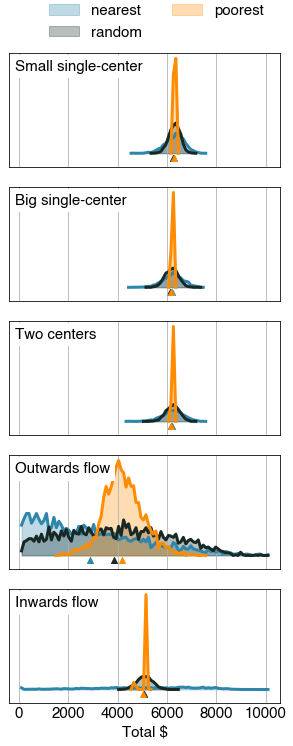

In [52]:
# selecting a specific part of the dataframe

cond1 = (df['d']== 258)
cond2 = (df['R']==0.4)
cond4 = (df['behaviour']=='stay') & (df['initial_conditions']=='base')

# waiting
sdf = copy.deepcopy(df[cond1&cond2&cond4])

sdf.index = sdf.index.map(lambda s: re.sub('random','random_limited',s))

sdf['incomes'] = sdf.index.map(get_incomes)
sdf = sdf[['geom','incomes','matching']]
sdf_flatten = sdf\
    .set_index(['geom','matching'])['incomes']\
    .apply(pd.Series)\
    .stack()\
    .reset_index(level=0)\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename(columns={0:'income'})
    
sdf['mean_incomes'] = sdf['incomes'].map(lambda l: np.mean(l))
t = sdf.pivot_table(index='geom',values='mean_incomes',columns='matching')#.plot(style='o',ax=ax)

data2 = sdf.pivot_table(values='incomes',index='geom',columns='matching',aggfunc=lambda x:x)

plt.rcParams['figure.figsize']=4.35,10
plt.rcParams['font.size']=fs
fig, ax = plt.subplots(5,1,sharex=True)

for i,g in enumerate([0,1,6,2,3]):
    y1,x1 = np.histogram(data2['nearest'][g],bins=100,range=(0,10100),density=True)
    filt1=(y1!=0)|(np.roll(y1,1)!=0)|(np.roll(y1,-1)!=0)
    
    y2,x2 = np.histogram(data2['random'][g],bins=100,range=(0,10100),density=True)
    filt2=(y2!=0)|(np.roll(y2,1)!=0)|(np.roll(y2,-1)!=0)
    
    y3,x3 = np.histogram(data2['poorest'][g],bins=100,range=(0,10100),density=True)
    filt3=(y3!=0)|(np.roll(y3,1)!=0)|(np.roll(y3,-1)!=0)
    
    
    ax[i].plot(x1[1:][filt1],y1[filt1],'-',lw=3,color=colors[2])
    ax[i].plot(x1[1:][filt2],y2[filt2],'-',lw=3,color=colors[3])
    ax[i].plot(x1[1:][filt3],y3[filt3],'-',lw=3,color=colors[6])
    
    ymax = ax[i].get_ylim()[1]
    offset=0.05
    ax[i].scatter(np.mean(data2['nearest'][g]),-ymax*offset,marker='^',color=colors[2])
    ax[i].scatter(np.mean(data2['random'][g]), -ymax*offset,marker='^',color=colors[3])
    ax[i].scatter(np.mean(data2['poorest'][g]),-ymax*offset,marker='^',color=colors[6])
    
    ax[i].fill_between(x1[1:][filt1],y1[filt1],y2=0,color=colors[2],alpha=0.3,label="nearest")
    ax[i].fill_between(x1[1:][filt2],y2[filt2],y2=0,color=colors[3],alpha=0.3,label="random")
    ax[i].fill_between(x1[1:][filt3],y3[filt3],y2=0,color=colors[6],alpha=0.3,label="poorest")
    
    ax[i].grid(which='major',axis='y')
    ax[i].get_yaxis().set_visible(False)
    ax[i].tick_params(length=0)

    ax[i].annotate(s=geom_descr[g],xy=(0.02,0.85),xycoords='axes fraction',backgroundcolor='white',fontsize=fs)
    
ax[4].set_xlabel('Total $')
fig.legend(*ax[0].get_legend_handles_labels(),loc='upper center',bbox_to_anchor=(0.5,1.05),frameon=False,ncol=2)
fig.tight_layout()
plt.savefig('different_algs.pdf',bbox_inches='tight')